In [1]:
# 挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, SVHN
from torch.utils.data import DataLoader

# 数据预处理
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载MNIST数据集
mnist_train = MNIST(root='/content', train=True, download=True, transform=transform)
mnist_test = MNIST(root='/content', train=False, download=True, transform=transform)

# 加载SVHN数据集
svhn_train = SVHN(root='/content', split='train', download=True, transform=transform)
svhn_test = SVHN(root='/content', split='test', download=True, transform=transform)

# 数据加载器
mnist_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
svhn_loader = DataLoader(svhn_train, batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5055532.85it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 58018.62it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 245613.21it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3617646.94it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 182040794/182040794 [00:26<00:00, 6748736.12it/s]


100%|██████████| 64275384/64275384 [00:13<00:00, 4673387.93it/s]


Epoch 1/20, Loss: 0.10557617247104645
Epoch 2/20, Loss: 0.16352398693561554
Epoch 3/20, Loss: 0.016439048573374748
Epoch 4/20, Loss: 0.09733480960130692
Epoch 5/20, Loss: 0.03947287052869797
Epoch 6/20, Loss: 0.0002241381152998656
Epoch 7/20, Loss: 0.0024749916046857834
Epoch 8/20, Loss: 0.014569271355867386
Epoch 9/20, Loss: 0.0008762502111494541
Epoch 10/20, Loss: 7.486074173357338e-05
Epoch 11/20, Loss: 0.0010960589861497283
Epoch 12/20, Loss: 0.00015367673768196255
Epoch 13/20, Loss: 0.0013462394708767533
Epoch 14/20, Loss: 0.0006453025853261352
Epoch 15/20, Loss: 8.699010504642501e-05
Epoch 16/20, Loss: 0.009622526355087757
Epoch 17/20, Loss: 0.0057226973585784435
Epoch 18/20, Loss: 4.8848134611034766e-05
Epoch 19/20, Loss: 1.6711932403268293e-05
Epoch 20/20, Loss: 0.0010375401470810175


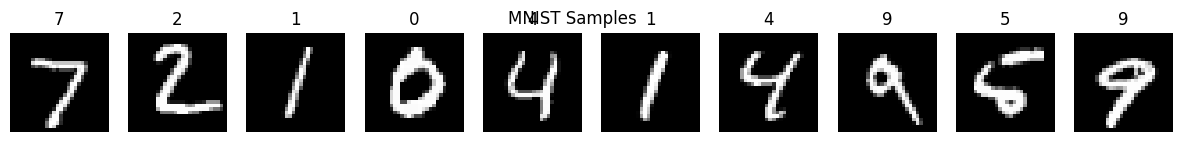

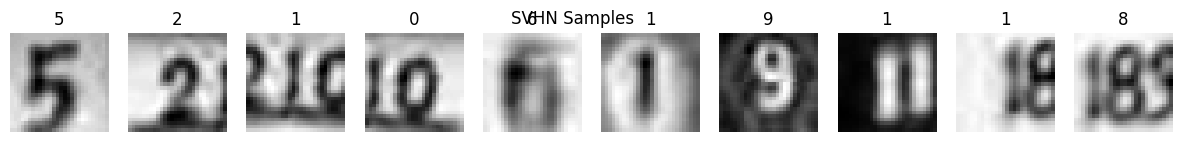

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function

# 梯度反转层
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambd, None

def grad_reverse(x, lambd=1.0):
    return GradReverse.apply(x, lambd)

class DomainAdaptationModel(nn.Module):
    def __init__(self):
        super(DomainAdaptationModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 48, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(48*4*4, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(48*4*4, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )

    def forward(self, x, alpha):
        features = self.feature_extractor(x)
        features = features.view(-1, 48*4*4)
        reverse_features = grad_reverse(features, alpha)
        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)
        return class_output, domain_output

# 初始化模型
model = DomainAdaptationModel()

# 训练参数
num_epochs = 20
learning_rate = 0.001
alpha = 0.1

# 优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.CrossEntropyLoss()

# 训练模型
for epoch in range(num_epochs):
    model.train()
    for (data, target), (svhn_data, _) in zip(mnist_loader, svhn_loader):
        optimizer.zero_grad()

        # 源域数据
        class_output, domain_output = model(data, alpha)
        class_loss = class_criterion(class_output, target)
        domain_loss = domain_criterion(domain_output, torch.zeros(domain_output.size(0)).long())

        # 目标域数据
        _, domain_output = model(svhn_data, alpha)
        target_domain_loss = domain_criterion(domain_output, torch.ones(domain_output.size(0)).long())

        loss = class_loss + domain_loss + target_domain_loss
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 可视化源域和目标域图片
def visualize_samples(dataset, title):
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    for i, (img, label) in enumerate(dataset):
        if i >= 10:
            break
        axes[i].imshow(img.numpy().squeeze(), cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

visualize_samples(mnist_test, 'MNIST Samples')
visualize_samples(svhn_test, 'SVHN Samples')


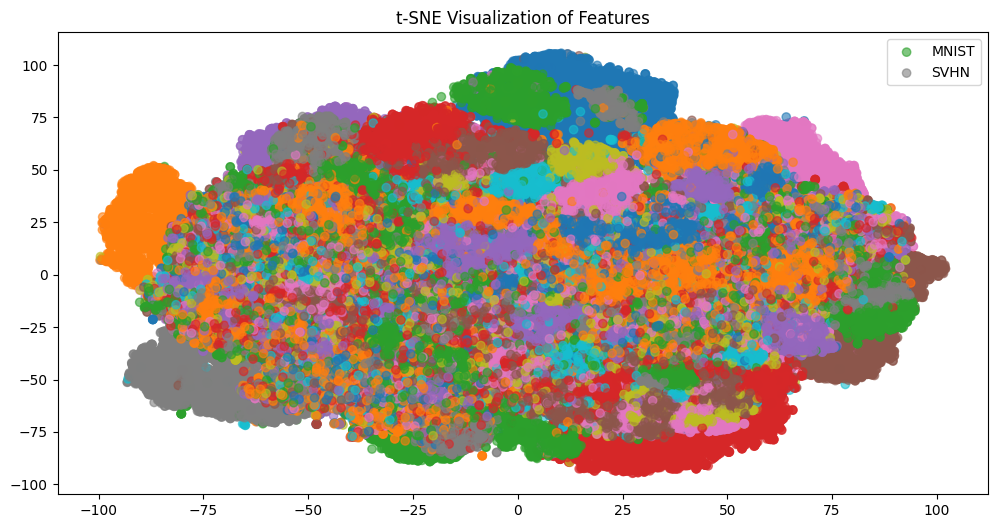

In [8]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 获取特征
def get_features(dataset_loader):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for data, target in dataset_loader:
            features = model.feature_extractor(data).view(data.size(0), -1)
            features_list.append(features.numpy())
            labels_list.append(target.numpy())
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

mnist_features, mnist_labels = get_features(mnist_loader)
svhn_features, svhn_labels = get_features(svhn_loader)

# t-SNE 可视化
tsne = TSNE(n_components=2)
mnist_tsne = tsne.fit_transform(mnist_features)
svhn_tsne = tsne.fit_transform(svhn_features)

plt.figure(figsize=(12, 6))
plt.scatter(mnist_tsne[:, 0], mnist_tsne[:, 1], c=mnist_labels, cmap='tab10', alpha=0.6, label='MNIST')
plt.scatter(svhn_tsne[:, 0], svhn_tsne[:, 1], c=svhn_labels, cmap='tab10', alpha=0.6, label='SVHN')
plt.legend()
plt.title('t-SNE Visualization of Features')
plt.show()


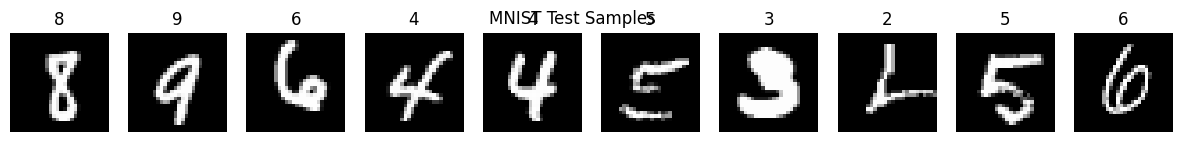

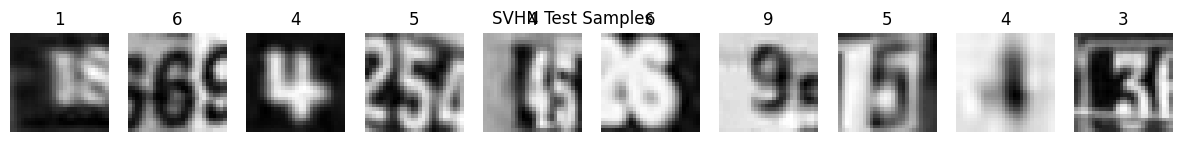

In [10]:
def show_samples(data_loader, title, num_samples=10):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:num_samples]
    labels = labels[:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 1.5))
    for idx, (img, lbl) in enumerate(zip(images, labels)):
        axes[idx].imshow(img.numpy().squeeze(), cmap='gray')
        axes[idx].set_title(lbl.item())
        axes[idx].axis('off')
    plt.suptitle(title)
    plt.show()

# 展示MNIST测试样本
show_samples(DataLoader(mnist_test, batch_size=64, shuffle=True), 'MNIST Test Samples')

# 展示SVHN测试样本
show_samples(DataLoader(svhn_test, batch_size=64, shuffle=True), 'SVHN Test Samples')
